In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima






In [4]:
df=pd.read_csv('Denawaka_project.csv')
df.head()








,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,233.6,22.1,32.1,NaN,NaN
1,2010,February,111.9,22.6,33.9,NaN,NaN
2,2010,March,157.5,23.1,35.2,NaN,NaN
3,2010,April,438.3,23.7,33.5,NaN,NaN
4,2010,May,658.5,24.0,31.8,NaN,NaN


In [5]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)







In [6]:
df.head()






,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,233.6,22.1,32.1,NaN,NaN,2010-January
1,2010,February,111.9,22.6,33.9,NaN,NaN,2010-February
2,2010,March,157.5,23.1,35.2,NaN,NaN,2010-March
3,2010,April,438.3,23.7,33.5,NaN,NaN,2010-April
4,2010,May,658.5,24.0,31.8,NaN,NaN,2010-May


In [7]:
hum_min=df[["Time","Hum_min"]]
hum_min.head()








,Time,Hum_min
0,2010-January,NaN
1,2010-February,NaN
2,2010-March,NaN
3,2010-April,NaN
4,2010-May,NaN


In [8]:
hum_min['Time']=pd.to_datetime(hum_min['Time'])


C:\Users\wasan\AppData\Local\Temp/ipykernel_6996/3648415634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hum_min['Time']=pd.to_datetime(hum_min['Time'])


In [9]:
hum_min.head()


,Time,Hum_min
0,2010-01-01,NaN
1,2010-02-01,NaN
2,2010-03-01,NaN
3,2010-04-01,NaN
4,2010-05-01,NaN


In [10]:
#Checking for missing values
hum_min.isna().sum()






Time        0
Hum_min    14
dtype: int64

In [11]:
#Setting the time index
hum_min.set_index('Time',inplace=True)

In [12]:
hum_min=hum_min.resample('MS').first()

In [13]:
#filling missing values
hum=hum_min.fillna(method='bfill')
hum.head(20)






,Hum_min
Time,
2010-01-01,79.0
2010-02-01,79.0
2010-03-01,79.0
2010-04-01,79.0
2010-05-01,79.0
2010-06-01,79.0
2010-07-01,79.0
2010-08-01,79.0
2010-09-01,79.0


In [14]:
#Checking for missing values
hum.isna().sum()

Hum_min    0
dtype: int64

In [15]:
hum = hum.rename(columns = {'Hum_min': 'Humidity'})
hum.head()








,Humidity
Time,
2010-01-01,79.0
2010-02-01,79.0
2010-03-01,79.0
2010-04-01,79.0
2010-05-01,79.0


In [16]:
hum.columns






Index(['Humidity'], dtype='object')

<AxesSubplot:xlabel='Time'>

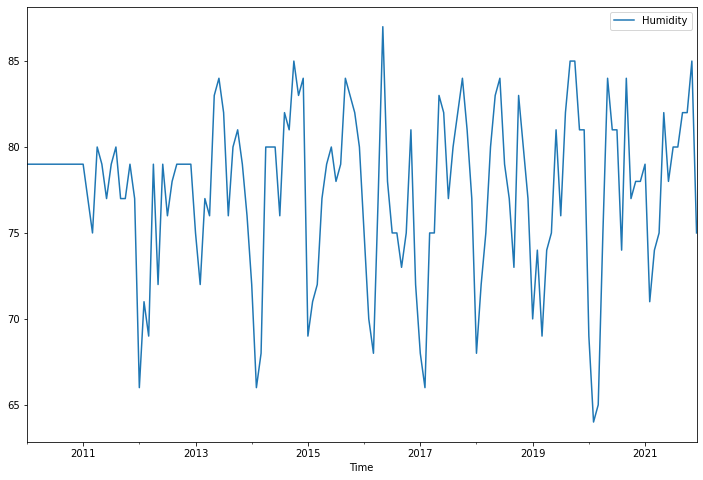

In [17]:
hum.plot(figsize=(12,8))





No trend. But some evidence for seasonality

# Testing For Stationarity

In [18]:
### ADF Test
test_result=adfuller(hum['Humidity'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(hum['Humidity'])





ADF Test Statistic : -3.5501343254243825
p-value : 0.006789113877352049
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [19]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(hum['Humidity'])


KPSS Statistic: 0.06329735723939389
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [20]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(hum['Humidity'].astype(float))
print(pp.summary().as_text())





     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.883
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Therefore the series is stationary

# ACF and PACF plots

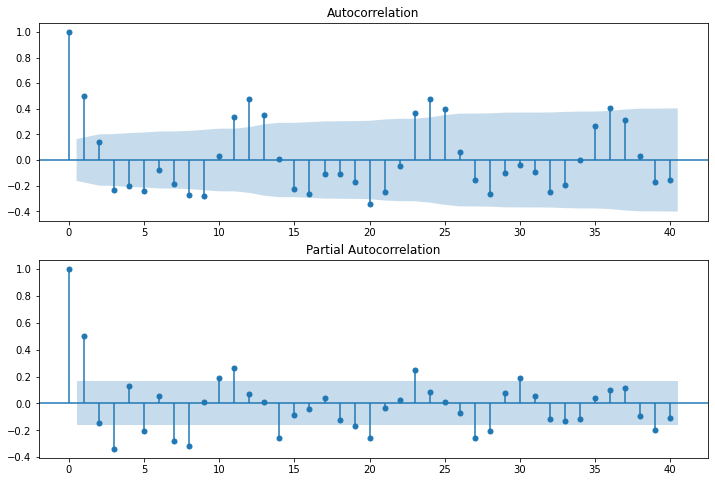

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hum['Humidity'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hum['Humidity'],lags=40,ax=ax2)


According to the PACF and ACF plots it's better to start with p=3, d=0, q=5

In [22]:
arima_model=auto_arima(hum['Humidity'].astype(float),start_p=0,start_d=0,start_q=0,max_p=3,max_D=1,max_q=5,start_P=0,start_D=0,start_Q=0,max_P=3,max_Q=5,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=70,maxiter=70,alpha=0.05)


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=860.191, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=840.977, Time=0.14 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=825.288, Time=0.53 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=822.400, Time=1.18 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=818.999, Time=1.86 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=inf, Time=17.24 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=825.635, Time=1.81 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=803.385, Time=0.94 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=825.417, Time=2.27 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=803.584, Time=4.77 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=inf, Time=8.16 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=807.309, Time=2.44 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=800.601, Time=1.82 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=831.406, Time=2.30 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=7.39 sec
 ARIMA(0,0,0)(3,0,0)[

C:\Users\wasan\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(2,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=801.741, Time=0.74 sec
 ARIMA(1,0,3)(0,0,1)[12] intercept   : AIC=796.931, Time=1.31 sec
 ARIMA(1,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(1,0,4)(0,0,0)[12] intercept   : AIC=803.711, Time=1.10 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=819.261, Time=0.20 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=811.847, Time=0.72 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=807.312, Time=0.99 sec
 ARIMA(2,0,0)(0,0,3)[12] intercept   : AIC=805.251, Time=6.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=809.455, Time=1.63 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=799.966, Time=1.92 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=798.719, Time=3.80 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=800.788, Time=3.77 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=791.940, Time=23.06 sec
 ARIMA(2,0,1)(0,0,0)[1

# Forecast Humidity using the model

In [23]:
model=sm.tsa.statespace.SARIMAX(hum["Humidity"].astype('float'),order=(1, 0, 2),seasonal_order=(1,0,1,12))
results=model.fit()
results.summary()


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Humidity   No. Observations:                  144
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -396.092
Date:                              Tue, 26 Apr 2022   AIC                            804.184
Time:                                      21:13:19   BIC                            822.003
Sample:                                  01-01-2010   HQIC                           811.425
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.002    416.257      0.000       0.994       1.004
ma.L1         -0.7069      0.083     -8.567      0.000      -0.869      -0.545
ma.L2         -0.2254      0.085     -2.651      0.008      -0.392      -0.059
ar.S.L12       0.9979      0.011     89.805      0.000       0.976       1.020
ma.S.L12      -0.9414      0.137     -6.885      0.000      -1.209      -0.673
sigma2        11.8587      2.116      5.605      0.000       7.712      16.005
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 1.63
Prob(Q):                              0.56   Prob(JB):                         0.44
Heteroskedasticity (H):               1.56   Skew:                            -0.26
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
hum.tail()

,Humidity
Time,
2021-08-01,80.0
2021-09-01,82.0
2021-10-01,82.0
2021-11-01,85.0
2021-12-01,75.0


In [29]:
beg_dt='2025-01-01'
end_dt='2025-12-01'

In [30]:
results.predict(start=beg_dt,end=end_dt,dynamic=True)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


2025-01-01    72.712846
2025-02-01    71.518634
2025-03-01    72.520385
2025-04-01    77.087460
2025-05-01    80.198963
2025-06-01    79.909898
2025-07-01    78.044510
2025-08-01    78.302095
2025-09-01    79.681352
2025-10-01    80.462288
2025-11-01    80.247134
2025-12-01    77.813034
Freq: MS, Name: predicted_mean, dtype: float64

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time'>

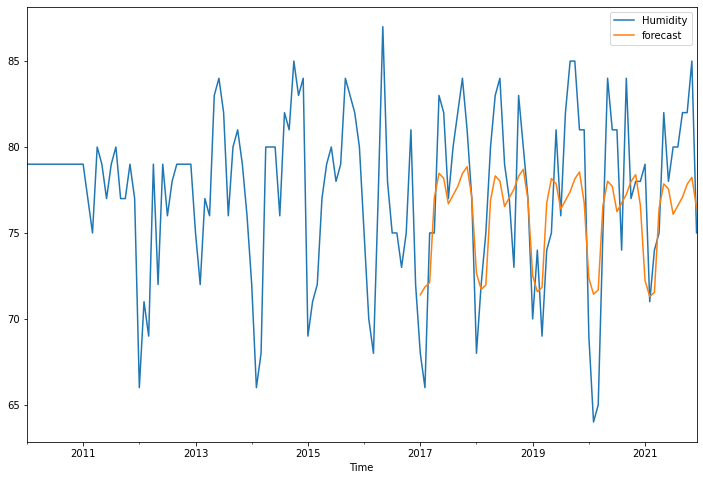

In [52]:
hum['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
hum[['Humidity','forecast']].plot(figsize=(12,8))


In [53]:
hum.tail()


,Humidity,forecast
Time,,
2021-08-01,80.0,76.589337
2021-09-01,82.0,77.089718
2021-10-01,82.0,77.835960
2021-11-01,85.0,78.234660
2021-12-01,75.0,76.464655
